# Model klasyfikujący sekwencje

Klasyczny ML na cechach sekwencji:
- ekstrakcja cech z całej sekwencji (np. min/max/średnia/odchylenie dla
współrzędnych i prędkości, statystyki kątów),
- klasyfikator: SVM, Random Forest, Gradient Boosting itp.

⚠️ Należy (jednorazowo) doinstalować biblioteke scikit-learn:<br>

In [1]:
%pip install scikit-learn

  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 4.2 MB/s eta 0:00:02
   -------------- ------------------------- 3.1/8.9 MB 9.2 MB/s eta 0:00:01
   ------------------------ --------------- 5.5/8.9 MB 10.2 MB/s eta 0:00:01
   ----------------------------------- ---- 7.9/8.9 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 9.5 MB/s eta 0:00:00
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- ----

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

### Wczytanie danych

In [2]:
data_path = '../data/dataset_urfall.npz'

if not os.path.exists(data_path):
    print(f"BŁĄD: Nie znaleziono pliku {data_path}")
else:
    print(f"Wczytuje dane z {data_path}...")
    with np.load(data_path) as data:
        X = data['X'] # znormalizowane punkty po preprocessingu
        y = data['y'] # etykiety (0 - stoi, 1 - leży)

    print(f"Wczytano {len(X)} próbek.")

print(f"\nKształt danych X (oryginalny): {X.shape}")
print(f"Kształt danych y: {y.shape}")

# zmiana (N, 17, 2) -> (N, 34)
X = X.reshape(X.shape[0], -1)
print(f"\nKształt danych X (po reshape): {X.shape}")

Wczytuje dane z ../data/dataset_urfall.npz...
Wczytano 9627 próbek.

Kształt danych X (oryginalny): (9627, 17, 2)
Kształt danych y: (9627,)

Kształt danych X (po reshape): (9627, 34)


### Podział na zbiór treningowy i testowy

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Zbiór treningowy: {len(X_train)}")
print(f"Zbiór testowy: {len(X_test)}")

Zbiór treningowy: 7701
Zbiór testowy: 1926


## Uczenie modeli

### Model Random Forest 🌲

Dokładność (Accuracy): 0.995

Raport klasyfikacji
              precision    recall  f1-score   support

        Stoi       1.00      1.00      1.00      1466
        Leży       0.98      1.00      0.99       460

    accuracy                           1.00      1926
   macro avg       0.99      1.00      0.99      1926
weighted avg       1.00      1.00      1.00      1926



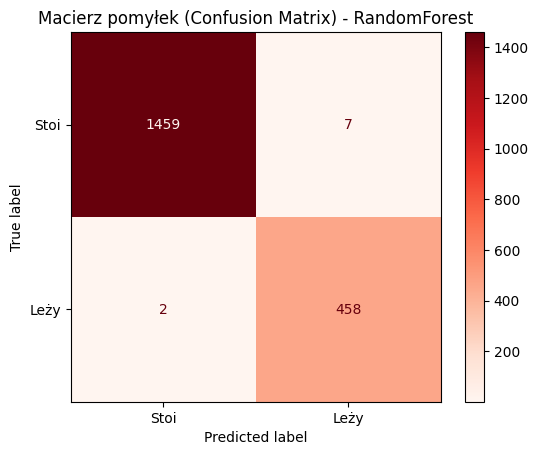

In [11]:
# tworzenie i uczenie modelu
rf_model = RandomForestClassifier(n_estimators=100, random_state=67, n_jobs=-1)
rf_model.fit(X_train, y_train)

# ewaluacja modelu (predykcje)
y_pred_rf = rf_model.predict(X_test)

# miary jakości modelu
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Dokładność (Accuracy): {rf_acc:.3f}")
print("\nRaport klasyfikacji")
print(classification_report(y_test, y_pred_rf, target_names=['Stoi', 'Leży']))

# macierz pomyłek
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['Stoi', 'Leży']).plot(cmap='Reds')
plt.title(f'Macierz pomyłek (Confusion Matrix) - RandomForest')
plt.show()

### Model SVM 📐

Dokładność (Accuracy): 0.986

Raport klasyfikacji
              precision    recall  f1-score   support

        Stoi       0.99      1.00      0.99      1466
        Leży       0.98      0.96      0.97       460

    accuracy                           0.99      1926
   macro avg       0.99      0.98      0.98      1926
weighted avg       0.99      0.99      0.99      1926



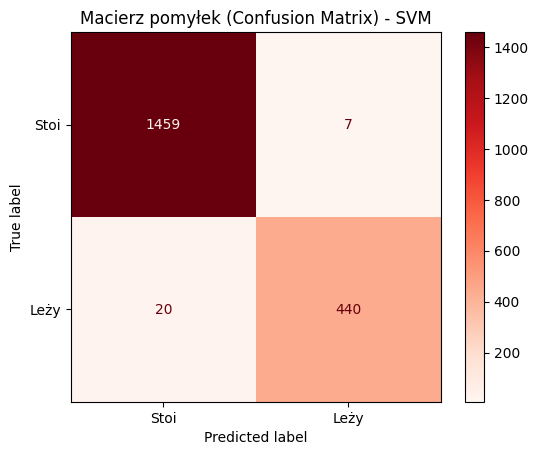

In [13]:
# tworzenie i uczenie modelu
svm_model = SVC(C=1, kernel='rbf', probability=True, random_state=67)
svm_model.fit(X_train, y_train)

# ewaluacja modelu (predykcje)
y_pred_svm = svm_model.predict(X_test)

# miary jakości modelu
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"Dokładność (Accuracy): {svm_acc:.3f}")
print("\nRaport klasyfikacji")
print(classification_report(y_test, y_pred_svm, target_names=['Stoi', 'Leży']))

# macierz pomyłek
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm, display_labels=['Stoi', 'Leży']).plot(cmap='Reds')
plt.title("Macierz pomyłek (Confusion Matrix) - SVM")
plt.show()